# 3DeeCellTracker Demo: Ensemble mode | Use StarDist

This notebook shows how to use 3DeeCellTracker to track cells in ensemble mode. The segmentation is basded on the trained StarDist.

The demo data and pre-trained deep neural network models can be found in the "worm4", "stardist_models" and "ffn_models" folders downloaded from https://osf.io/pgr95/

**The basic procedures:**
- A. Import packages
- B. Segment cells by StarDist3D
- C. Load manually corrected segmentation (t=1)
- D. Track cells by FFN + PRGLS + Fine-tune.
- E. Extract activities from the tracked cells.

## A. Import packages

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
import numpy as np

import CellTracker.trackerlite as trl
import CellTracker.stardistwrapper as sdw
import CellTracker.coord_image_transformer as cit
from CellTracker.analyses import draw_signals

## B. Segment cells by StarDist3D
### Load trained StarDist3D model

### Parameters
- `model_name`: A string specifying the name of the model to reload.

### Notes:
> By default, the function looks for the model with the specified name from the stardist_models directory. However, if you have saved the model in a different location, you can specify the `basedir` parameter to load the model from that directory.
```
    model = sdw.load_stardist_model(model_name=stardist_model_name, basedir=".\FolderA\FolderB\")
```

In [2]:
stardist_model_name = "stardist_worm1"

model = sdw.load_stardist_model(model_name=stardist_model_name)

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.637042, nms_thresh=0.3.
Load pretrained stardist model 'stardist_worm1' from folder 'stardist_models'


2024-11-22 03:21:08.110001: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-22 03:21:08.491383: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79048 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:44:00.0, compute capability: 8.0


In [3]:
model.config

Config3D(anisotropy=(1.0, 3.0, 3.0), axes='ZYXC', backbone='unet', grid=(2, 1, 1), n_channel_in=1, n_channel_out=97, n_classes=None, n_dim=3, n_rays=96, net_conv_after_unet=128, net_input_shape=[None, None, None, 1], net_mask_shape=[None, None, None, 1], rays_json={'name': 'Rays_GoldenSpiral', 'kwargs': {'n': 96, 'anisotropy': (1.0, 3.0, 3.0)}}, train_background_reg=0.0001, train_batch_size=2, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_class_weights=[1, 1], train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=[1, 0.2], train_n_val_patches=None, train_patch_size=[144, 48, 48], train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_sample_cache=True, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=[3, 3, 3], unet_last_activation='relu', unet_n_conv

### Segment the volume #1 image and save the segmentation in auto_vol1 folder

### Parameters
- `path_results`: A string specifying a directory to save the segmentation/tracking results.
- `path_raw_images`: A string specifying the file path to the raw images.

### Notes
> All of the time-lapse 3D images should be stored in a single directory. Each 3D image at time t should be saved as a sequence of 2D slices in TIFF format. The filename of each 2D image should contain the timing and slice number, such as "xxx_txxx_z_xxx.tif". To ensure that the program correctly loads the images for each timing, users should specify the format of the timing in the filename in the `path_raw_images` parameter. For example, "t%03d.tif" indicates that the filename should contain the letter "t" followed by a 3-digit number representing the timing, followed by any number of characters, and ending with the extension ".tif".

Raw image shape at vol1: (150, 400, 1404) float32
Raw image shape at vol1: (150, 400, 1404) float32
effective: block_size=(144, 252, 252), min_overlap=(24, 20, 20), context=(48, 48, 48)


2024-11-22 03:21:12.455795: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2024-11-22 03:21:15.924380: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8700
100%|███████████████████████████████████████████| 60/60 [02:52<00:00,  2.88s/it]


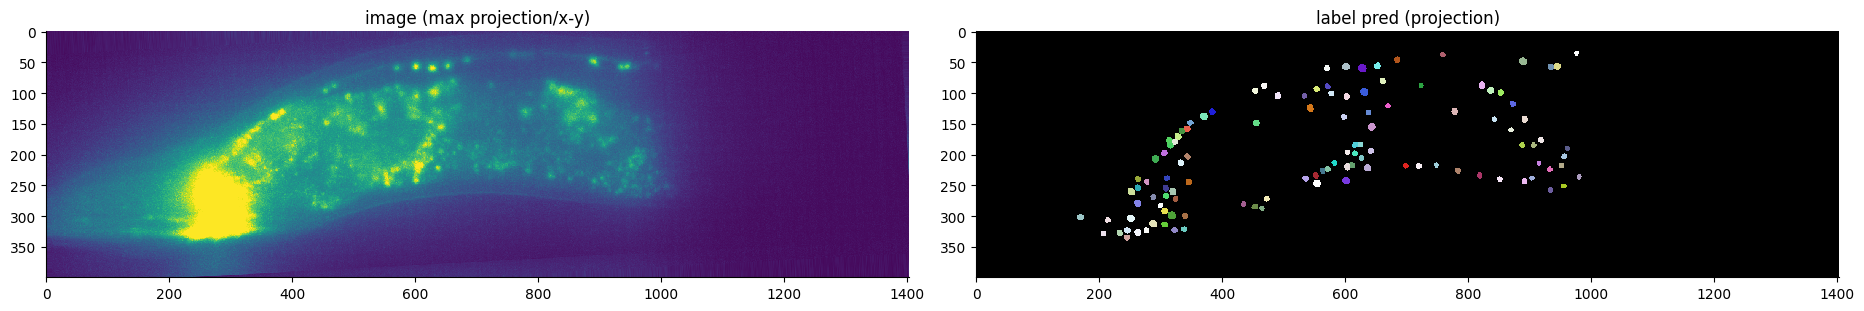

In [4]:
path_results = "results/"
path_raw_images = "*t%04d*.tif" #2d slices

# Load raw image at vol 1
vol = 1
x = sdw.load_2d_slices_at_time(path_raw_images, t=vol)
print(f"Raw image shape at vol1: {x.shape} {x.dtype}")

# x = tf.cast(x, dtype=tf.int8)
print(f"Raw image shape at vol1: {x.shape} {x.dtype}")
labels, details, prob_map = model.predict_instances_big(x,'ZYX',block_size=(140,250,250),min_overlap=(22, 20, 20),context = 46)
use_8_bit = True if labels.max() <= 255 else False

sdw.plot_img_label_max_projection(x, labels, lbl_title="label pred (projection)", fig_width_px=1800)

### Displaying max projections of raw images and predicted segmentation in x-z plane

### Parameters
- `scale_z`: A number (>0) specifying the scaling rate along the z-axis. This is useful when the resolution in the z-axis is significantly different from that in the x-axis.

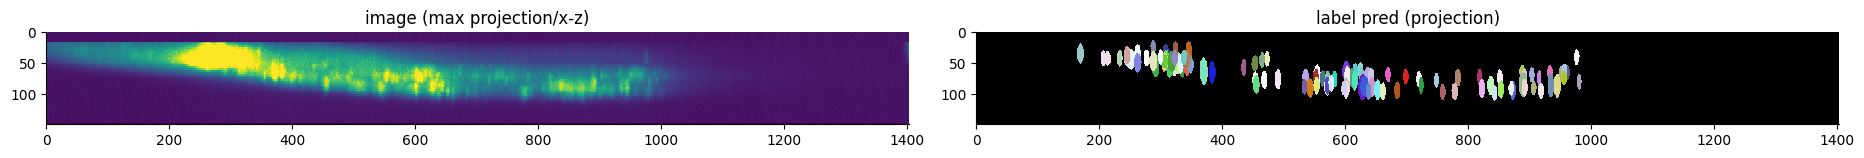

In [6]:
scale_z = 1

sdw.plot_img_label_max_projection_xz(x, labels, lbl_title="label pred (projection)", fig_width_px=1800, scale_z=scale_z)

### Segment all volumes 
The following code block segments cells in all volumes and saves the predicted cell coordinates and probability maps in the "seg" folder automatically.

In [7]:
# Initialize the dictionary
block_details = {}

# Add values to the dictionary with appropriate keys
block_details['block_size'] = (140, 250, 250)
block_details['min_overlap'] = (22, 20, 20)
block_details['context'] = 46

sdw.predict_and_save_big(images_path=path_raw_images, model=model, results_folder=path_results,blocks_details=blocks_details)

Segmenting images:   0%|   | 0/20 [00:00<?, ?it/s]

effective: block_size=(144, 252, 252), min_overlap=(24, 20, 20), context=(48, 48, 48)



100%|███████████████████████████████████████████| 60/60 [02:51<00:00,  2.86s/it]
Segmenting images:   5%| | 1/20 [02:54<55:10, 174.

effective: block_size=(144, 252, 252), min_overlap=(24, 20, 20), context=(48, 48, 48)



100%|███████████████████████████████████████████| 60/60 [02:52<00:00,  2.87s/it]
Segmenting images:  10%| | 2/20 [05:48<52:21, 174.

effective: block_size=(144, 252, 252), min_overlap=(24, 20, 20), context=(48, 48, 48)



100%|███████████████████████████████████████████| 60/60 [02:55<00:00,  2.92s/it]
Segmenting images:  15%|▏| 3/20 [08:46<49:46, 175.

effective: block_size=(144, 252, 252), min_overlap=(24, 20, 20), context=(48, 48, 48)



100%|███████████████████████████████████████████| 60/60 [02:48<00:00,  2.81s/it]
Segmenting images:  20%|▏| 4/20 [11:37<46:21, 173.

effective: block_size=(144, 252, 252), min_overlap=(24, 20, 20), context=(48, 48, 48)



100%|███████████████████████████████████████████| 60/60 [02:52<00:00,  2.87s/it]
Segmenting images:  25%|▎| 5/20 [14:31<43:30, 174.

effective: block_size=(144, 252, 252), min_overlap=(24, 20, 20), context=(48, 48, 48)



100%|███████████████████████████████████████████| 60/60 [02:52<00:00,  2.87s/it]
Segmenting images:  30%|▎| 6/20 [17:25<40:37, 174.

effective: block_size=(144, 252, 252), min_overlap=(24, 20, 20), context=(48, 48, 48)



100%|███████████████████████████████████████████| 60/60 [02:46<00:00,  2.77s/it]
Segmenting images:  35%|▎| 7/20 [20:14<37:20, 172.

effective: block_size=(144, 252, 252), min_overlap=(24, 20, 20), context=(48, 48, 48)



100%|███████████████████████████████████████████| 60/60 [02:54<00:00,  2.90s/it]
Segmenting images:  40%|▍| 8/20 [23:10<34:43, 173.

effective: block_size=(144, 252, 252), min_overlap=(24, 20, 20), context=(48, 48, 48)



100%|███████████████████████████████████████████| 60/60 [02:51<00:00,  2.86s/it]
Segmenting images:  45%|▍| 9/20 [26:04<31:51, 173.

effective: block_size=(144, 252, 252), min_overlap=(24, 20, 20), context=(48, 48, 48)



100%|███████████████████████████████████████████| 60/60 [02:48<00:00,  2.80s/it]
Segmenting images:  50%|▌| 10/20 [28:55<28:47, 172

effective: block_size=(144, 252, 252), min_overlap=(24, 20, 20), context=(48, 48, 48)



100%|███████████████████████████████████████████| 60/60 [02:51<00:00,  2.86s/it]
Segmenting images:  55%|▌| 11/20 [31:49<25:58, 173

effective: block_size=(144, 252, 252), min_overlap=(24, 20, 20), context=(48, 48, 48)



100%|███████████████████████████████████████████| 60/60 [02:47<00:00,  2.78s/it]
Segmenting images:  60%|▌| 12/20 [34:38<22:56, 172

effective: block_size=(144, 252, 252), min_overlap=(24, 20, 20), context=(48, 48, 48)



100%|███████████████████████████████████████████| 60/60 [02:52<00:00,  2.87s/it]
Segmenting images:  65%|▋| 13/20 [37:33<20:09, 172

effective: block_size=(144, 252, 252), min_overlap=(24, 20, 20), context=(48, 48, 48)



100%|███████████████████████████████████████████| 60/60 [02:47<00:00,  2.80s/it]
Segmenting images:  70%|▋| 14/20 [40:23<17:12, 172

effective: block_size=(144, 252, 252), min_overlap=(24, 20, 20), context=(48, 48, 48)



100%|███████████████████████████████████████████| 60/60 [02:48<00:00,  2.80s/it]
Segmenting images:  75%|▊| 15/20 [43:14<14:17, 171

effective: block_size=(144, 252, 252), min_overlap=(24, 20, 20), context=(48, 48, 48)



100%|███████████████████████████████████████████| 60/60 [02:45<00:00,  2.76s/it]
Segmenting images:  80%|▊| 16/20 [46:02<11:21, 170

effective: block_size=(144, 252, 252), min_overlap=(24, 20, 20), context=(48, 48, 48)



100%|███████████████████████████████████████████| 60/60 [02:45<00:00,  2.76s/it]
Segmenting images:  85%|▊| 17/20 [48:50<08:29, 169

effective: block_size=(144, 252, 252), min_overlap=(24, 20, 20), context=(48, 48, 48)



100%|███████████████████████████████████████████| 60/60 [02:52<00:00,  2.87s/it]
Segmenting images:  90%|▉| 18/20 [51:44<05:42, 171

effective: block_size=(144, 252, 252), min_overlap=(24, 20, 20), context=(48, 48, 48)



100%|███████████████████████████████████████████| 60/60 [02:47<00:00,  2.79s/it]
Segmenting images:  95%|▉| 19/20 [54:34<02:50, 170

effective: block_size=(144, 252, 252), min_overlap=(24, 20, 20), context=(48, 48, 48)



 57%|████████████████████████▎                  | 34/60 [01:37<01:14,  2.87s/it]
Segmenting images:  95%|▉| 19/20 [56:13<02:57, 177


RuntimeError: Found object of shape (40, 12, 13), which violates the assumption of being smaller than 'min_overlap' (24, 20, 20). Increase 'min_overlap' to avoid this problem.

## C. Manual correction

### Perform manual correction
- Manually correct the segmentation results saved in the "auto_vol1" folder, use software like ITK-SNAP. 
- Save the corrected segmentation as 2D slices in the TIFF format in the "manual_vol1" folder.

### Load the manually corrected segmentation

### Parameters
- `voxel_size`: A tuple of 3 numbers, indicating the size (in arbitrary units) of a voxel in the x, y, and z directions.
- `manual_seg_path`: A string specifying the file path to the manually corrected segmentation images.

Loaded the proofed segmentations at vol 1 with 157 cells


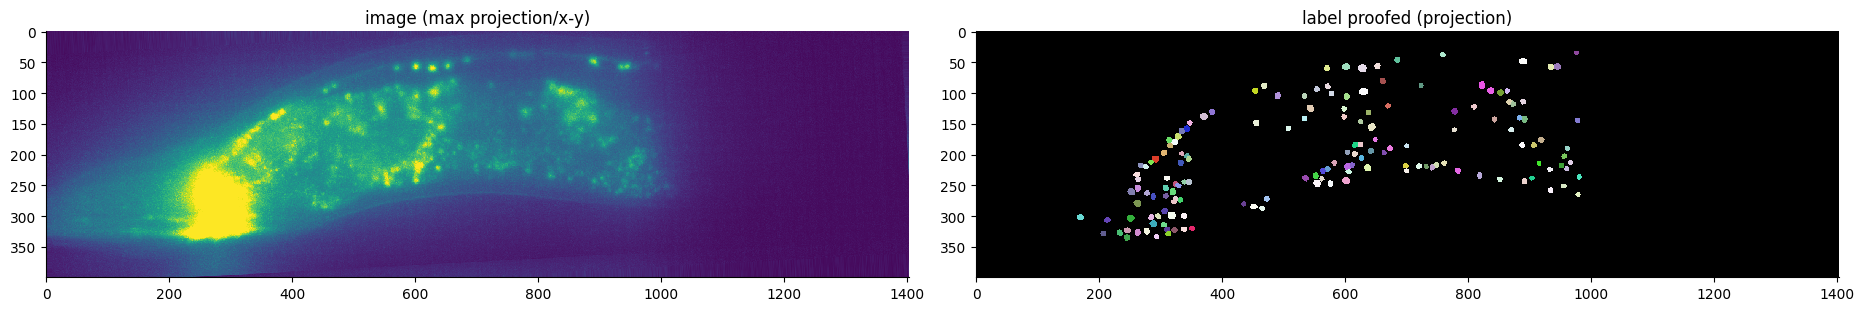

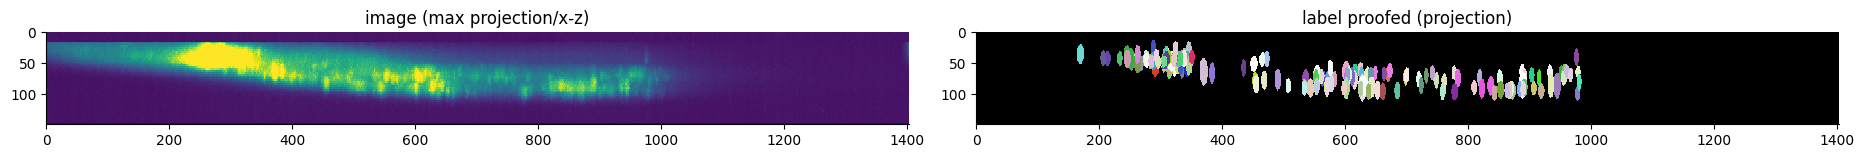

In [8]:
voxel_size=(1, 1, 1)
manual_seg_path="/results/manual_vol1/*.tif"

coords2image = cit.CoordsToImageTransformer(results_folder=path_results, voxel_size=voxel_size)
coords2image.load_segmentation(manual_seg_path)
sdw.plot_img_label_max_projection(x, coords2image.proofed_segmentation.transpose(2,0,1), lbl_title="label proofed (projection)", fig_width_px=1800)
sdw.plot_img_label_max_projection_xz(x, coords2image.proofed_segmentation.transpose(2,0,1), lbl_title="label proofed (projection)", fig_width_px=1800, scale_z=scale_z)

### Perform interpolation along z axis

### Parameters
- `interpolation_factor`: An integer parameter (>= 1) that specifies the factor by which the number of z-slices in the original 3D image should be increased. For example, if the original image has 10 z-slices and factor is set to 2, then the new image will have 20 z-slices.

### Notes
> The interpolated results are used to refine the positions of the tracking results. Increasing the number of z-slices via interpolation can improve the accuracy of the estimated cell positions. 

> The program employs a Gaussian blur filter to generate the interpolation. Even if the `interpolation_factor` is set to 1, the program still applies the filter without increasing the number of slices.

Interpolating images along z-axis...
The interpolated segmentations at vol 1 contains 157 cells
Calculating coordinates of cell centers...


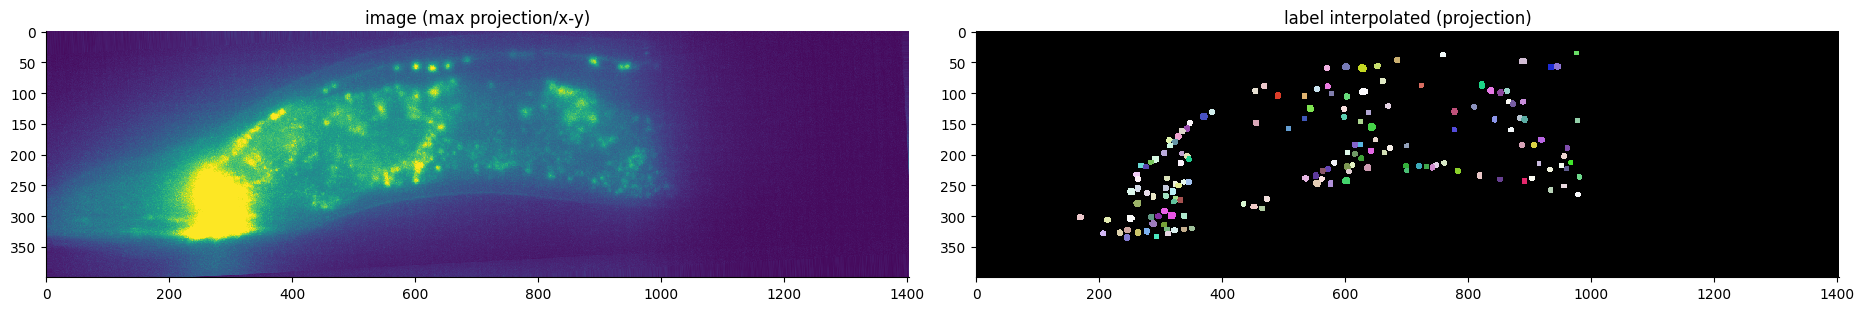

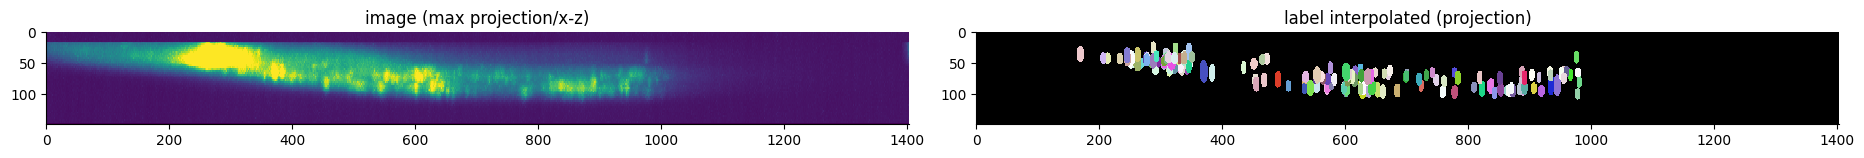

In [9]:
interpolation_factor = 1

coords2image.interpolate(interpolation_factor=interpolation_factor)
sdw.plot_img_label_max_projection(x, coords2image.auto_corrected_segmentation.transpose(2,0,1), lbl_title="label interpolated (projection)", fig_width_px=1800)
sdw.plot_img_label_max_projection_xz(x, coords2image.auto_corrected_segmentation.transpose(2,0,1), lbl_title="label interpolated (projection)", fig_width_px=1800,scale_z=scale_z)

## D. Tracking cells. 

### Initiate Tracker

### Parameters
- `ffn_model_name`: A string specifying the name of the ffn model to reload.

### Notes:
> By default, the function looks for the model with the specified name from the "ffn_models" directory. However, if you have saved the model in a different location, you can specify the `basedir` parameter to load the model from that directory.
```
    tracker = trl.TrackerLite(results_dir=path_results, ffn_model_name=ffn_model_name, proofed_coords_vol1=coords2image.coord_vol1, basedir=".\FolderA\FolderB\")
```    

In [10]:
ffn_model_name="ffn_worm4"

tracker = trl.TrackerLite(results_dir=path_results, ffn_model_name=ffn_model_name,basedir="", proofed_coords_vol1=coords2image.coord_vol1)

2024-11-22 06:03:03.237824: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [14]:
pwd

'/weka/scratch/weka/boydenlab/mansour8/package_dev/3DeeCellTracker/Examples/use_stardist'

### Test FFN matching

### Parameters
- `t1`: An integer specifying the volume number of the first segmentation
- `t2`: An integer specifying the volume number of the second segmentation

### Notes:
>  The program will match the segmented cell centers points (saved in the "seg" folder) between volumes t1 and t2.

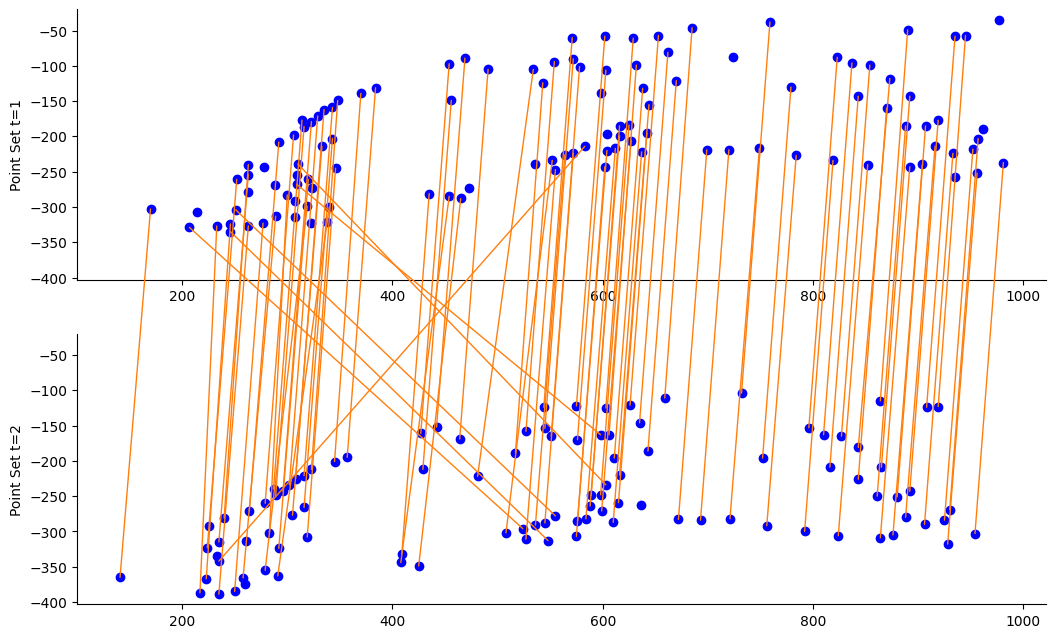

In [11]:
t1 = 1
t2 = 2

tracker.match_by_ffn(t1=t1, t2=t2)

### Test FFN + PR-GLS tracking

### Parameters
- `beta`: A numeric value (integer or float). A larger value will result in a larger window for estimating cell movement based on neighboring cells.
- `lambda_`: A numeric value (integer or float). A larger value will result in more similar movements across different cells.

### Notes:
> The program will estimate the new positions at time point `t2` for all cells segmented at time point `t1`. The FFN matching will be improved by PR-GLS to generate a more coherent estimation of cell movements.

> The default values of `beta` and `lambda_` are (3, 3), which are suitable for most cases. However, users can try different values to further improve the tracking.

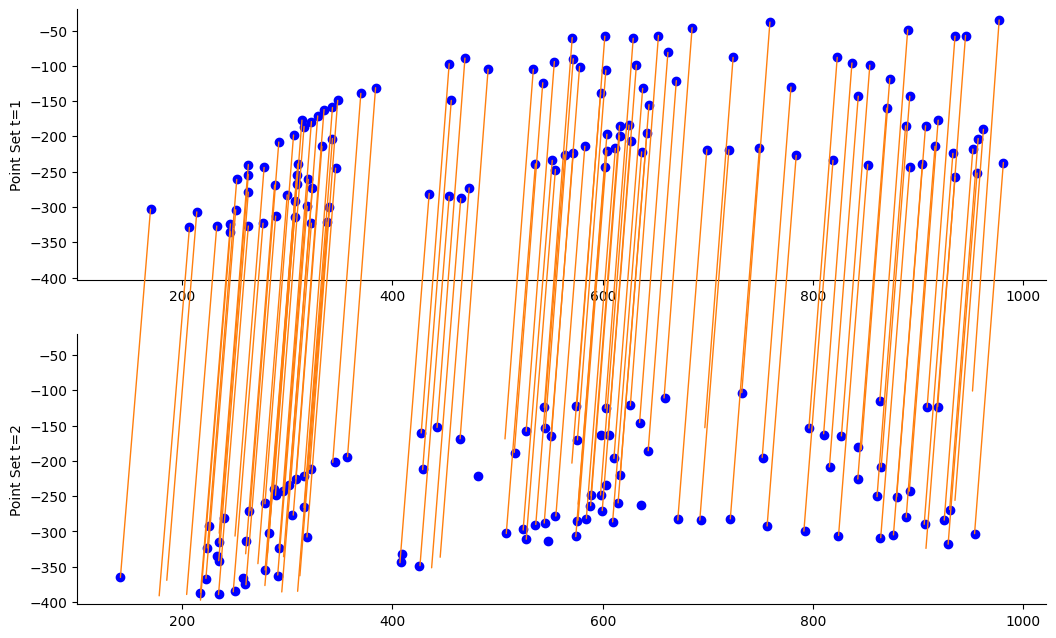

In [12]:
beta = 3
lambda_= 3

tracked_positions_t2 = tracker.predict_cell_positions(t1=t1, t2=t2, beta=beta, lambda_=lambda_, draw_fig=True)

### Track cells in following volumes in ensemble mode

### Parameters
- `t_start`: An integer specifying the volume number of the first raw image. Usually, this value is set to 1, so that the program will load coordinates in volume 2, 3, 4, and so on for tracking. If `t_start` is not 1, then the subsequent volume numbers will be `t_start + 1`, `t_start + 2`, and so on.
- `t_end`: An integer specifying the volume number of the last raw image that should be tracked.
- `skipped_volumes`: A list of integers specifying the volumes that should be skipped during tracking. An empty list [] means no volume will be skipped.

### Notes:
> All tracking results will be automatically saved in the "track_results" folder, including:
> 1. The coordinates of tracked cells (in the same units as the `voxel_size`) - Folder "coords_real"
> 2. Figures showing the tracking in each volume - Folder "figure"
> 3. Images of the tracked labels in each volume - Folder "labels"
> 4. Merged images of the raw image and the tracked labels in each volume, projected on the x-y plane - Folder "merged_labels"
> 5. Merged images of the raw image and the tracked labels in each volume, projected on the x-z plane - Folder "merged_labels_xz"

In [13]:
t_start = 1
t_end = 19
skipped_volumes = [20]

ensemble = True
t1 = t_start
confirmed_coord = coords2image.coord_vol1
grid = model.config.grid
for t in range(t_start+1, t_end+1):
    print(f"t={t}...", end="\r")
    if t in skipped_volumes:
        print(f"skip t={t}")
        continue
    coord_prgls = tracker.predict_cell_positions_ensemble(skipped_volumes=skipped_volumes, t2=t, coord_t1=confirmed_coord, beta=beta, lambda_=lambda_, 
                                                          sampling_number=20, adjacent=False, t_start=t_start)
    confirmed_coord, corrected_labels_image = coords2image.accurate_correction(t, grid, coord_prgls, ensemble)
    coords2image.save_tracking_results(confirmed_coord, corrected_labels_image, tracker, t1=t1, t2=t, images_path=path_raw_images)
    t1 = t

## E. Extract activities from tracked cells

### Extract activities

### Parameters
- `raw_path`: A string specifying the file path to the raw image to extract the activities. The image data should be in TIFF format.

### Notes
> This Code Block extracts activities from 3D time-lapse images, based on tracking results.

In [14]:
raw_path = "*t%04d*.tif"

activities = tracker.activities(raw_path=raw_path)

/weka/scratch/weka/boydenlab/mansour8/package_dev/3DeeCellTracker/dataset/dataset_large_slices/train_image/results/track_results/labels
1 19


### Draw a figure to show the activities

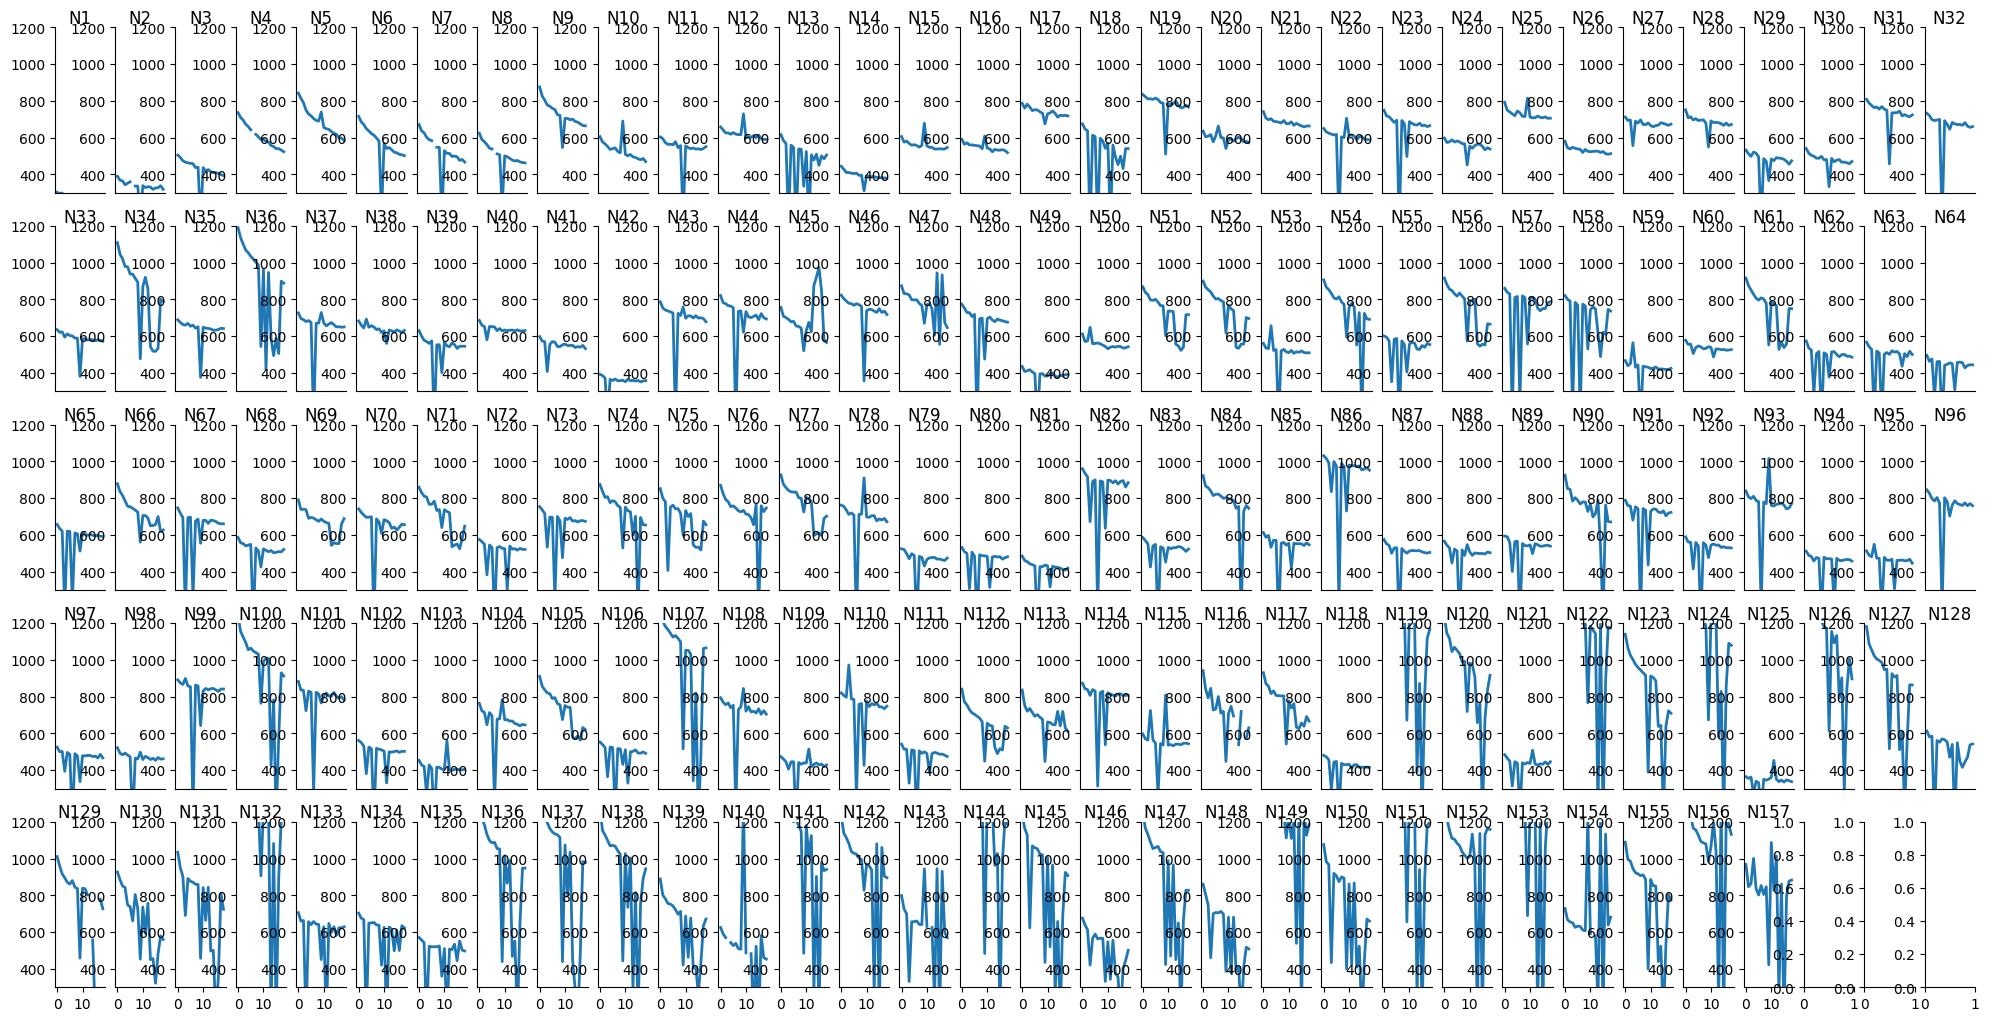

In [18]:
draw_signals(activities, ylim_lower=300, ylim_upper=1200, figsize=(20, 10))

### Export the activities as csv file

### Parameters
- `csv_filename`: The filename of the csv file to save the extracted activities

In [16]:
csv_filename = "activities_txcell.csv"

csv_filename = os.path.join(path_results, "activities_txcell.csv")
timings = np.arange(1, activities.shape[0]+1).reshape(-1, 1)
activities_with_timings = np.concatenate((timings, activities), axis=1)
headers = ['timing'] + ['cell' + str(i) for i in range(1, activities.shape[1]+1)]
np.savetxt(csv_filename, activities_with_timings, delimiter=',', fmt='%.3f', header=','.join(headers), comments='')
print(f"The cell activities have been saved in {csv_filename}")

The cell activities have been saved in /weka/scratch/weka/boydenlab/mansour8/package_dev/3DeeCellTracker//dataset/dataset_large_slices/train_image/results/activities_txcell.csv
